In [1]:
import cloudberry.api as cb

In [2]:
# Define Cloudberry configuration
cb_port = 9000
cb_config = cb.CloudberryConfig(f'http://localhost:{cb_port}')

# Initialize selected API(s)
cb_data = cb.Data(cb_config)
cb_analytics = cb.Analytics(cb_config)
cb_buckets = cb.Buckets(cb_config)
cb_meta = cb.Metadata(cb_config)
cb_query = cb.Query(cb_config)
cb_uploader = cb.AgeFileUploader(cb_config)
cb_csv_uploader = cb.CsvFileUploader(cb_config)

In [3]:
# cb.Data

import math
import datetime

get_current_timestamp = lambda: math.trunc(datetime.datetime.utcnow().timestamp())

current_time = get_current_timestamp()
data_points = [
    cb.DataPoint(time=current_time, fields={'version': 0.1}, tags={'origin': 'jupyter_notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 1, fields={'version': 0.2}, tags={'origin': 'jupyter_notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 2, fields={'version': 0.1}, tags={'origin': 'notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 3, fields={'version': 0.2}, tags={'origin': 'notebook', 'type': 'api_demo'}),
]

# Save data points explicitly
result = cb_data.save_data(data_points)
print(result)

# Get those data points with filters
result = cb_data.get_data(cb.DataFilters(tags={'origin': 'notebook'}))
print(len(result.data))

result = cb_data.get_data(cb.DataFilters(fields={'version': 0.1}))
print(len(result.data))

result = cb_data.get_data(cb.DataFilters(tags={'origin': 'notebook'}, fields={'version': 0.1}))
print(len(result.data), result.data)

# Delete data points
result = cb_data.get_data(cb.DataFilters(tags={'type': 'api_demo'}))
print('before: ', len(result.data))

result = cb_data.delete_data(cb.DataFilters(tags={'type': 'api_demo'}))
print(result)

result = cb_data.get_data(cb.DataFilters(tags={'type': 'api_demo'}))
print('after: ', len(result.data))

True
2
2
1 [{'_time': 1597867665.0, '_measurement': 'cloudberry-default', 'origin': 'notebook', 'type': 'api_demo', 'version': 0.1}]
before:  4
True
after:  0


In [4]:
# cb.Buckets

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

result = cb_buckets.create_bucket('wiadro_0')
print(result)

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

result = cb_buckets.delete_bucket('wiadro_0')
print(result)

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

['_tasks', '_monitoring', 'cloudberry-logs']
True
['_tasks', '_monitoring', 'cloudberry-logs', 'wiadro_0']
True
['_tasks', '_monitoring', 'cloudberry-logs']


In [5]:
# cb.Query

result = cb_query.query("""
from(bucket:"cloudberry-logs")
|> range(start: -1h)
|> filter(fn: (r) => r.type == "api_demo")
""", raw=True)
print(result)

b''


In [6]:
# cb.AgeFileUploader

age_log_file_path = '../data/emas-20190412T120536.log'
age_log_experiment_name = 'EMAS_AGE'
age_log_headers_keys = {
    "[WH]": "[W]",
    "[SH]": "[S]",
    "[BH]": "[B]"
}

computation_id = cb_uploader.upload_file(
    file_path=age_log_file_path,
    experiment_name=age_log_experiment_name,
    details=cb.AgeUploadDetails(headers_keys=age_log_headers_keys)
)
print(computation_id)

5f3da2b28d362d7a485d656a


In [7]:
# cb.Analytics

# Upload more data to Cloudberry
emas_files = [
    "../data/emas-20190411T232808.log",
    "../data/emas-20190411T234810.log",
    "../data/emas-20190412T000813.log",
    "../data/emas-20190412T120536.log",
]
computation_ids = []
for emas_file in emas_files:
    computation_id = cb_uploader.upload_file(
             file_path=emas_file,
             experiment_name=age_log_experiment_name,
             details=cb.AgeUploadDetails(headers_keys=age_log_headers_keys)
         )
    computation_ids.append(computation_id)

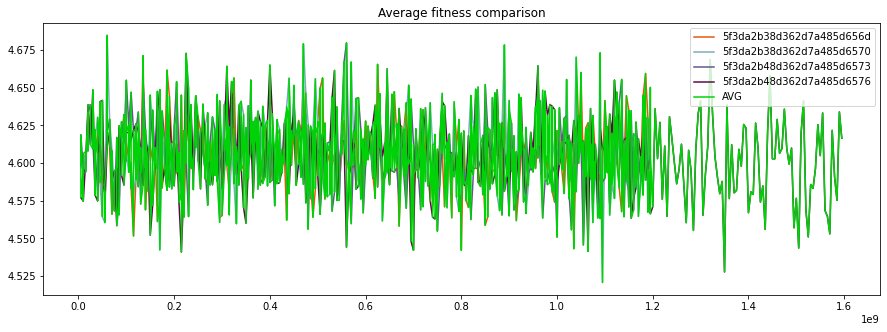

In [12]:
best_fitness_field = 'BEST_SOLUTION_SO_FAR'
fitness_field = 'AVERAGE_FITNESS'

# Use case 1. Compare multiple computations by their ids

series = cb_analytics.compare_computations(
    computation_ids=computation_ids,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

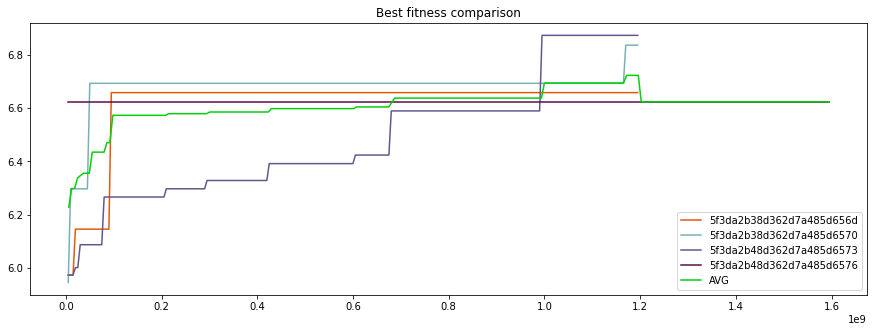

In [25]:
series = cb_analytics.compare_computations(
    computation_ids=computation_ids,
    field_name=best_fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=best_fitness_field,
                           title='Best fitness comparison')

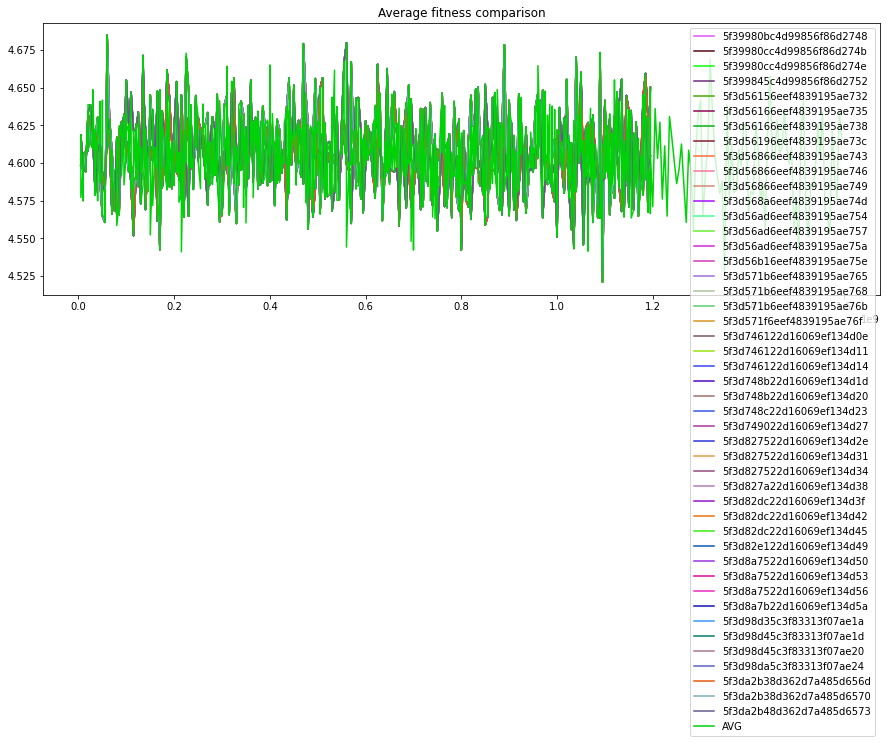

In [14]:
CONFIGURATION_ID = '5f39980bc4d99856f86d2747'

# Use case 2. Compare all computations for given configuration id

series = cb_analytics.compare_computations_for_configuration(
    configuration_id=CONFIGURATION_ID,
    field_name=fitness_field
)


cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

In [15]:
# Another feature: append data from CSV
# - must specify configuration ID explicitly as CSV does not contain experiment configuration

age_csv_file_path = '../data/emas_1.csv'

cb_csv_uploader.upload_file(
    file_path=age_csv_file_path,
    experiment_name=age_log_experiment_name,
    details=cb.CsvUploadDetails(
        tags_names=['WORKPLACE_ID'],
        configuration_id=CONFIGURATION_ID,
        computation_id=None # None for new computation
    )
)

'5f3da6ca0e81c03b06e0cd2f'

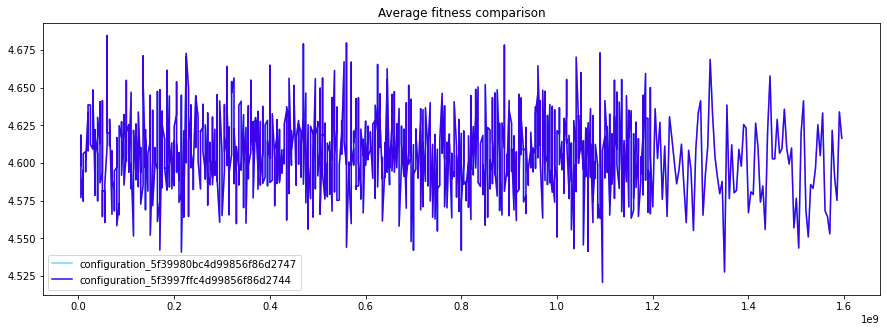

In [16]:
configuration_ids = [
    CONFIGURATION_ID,
    '5f3997ffc4d99856f86d2744'
]

# Use case 3. Compare N configurations

series = cb_analytics.compare_configurations(
    configuration_ids=configuration_ids,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

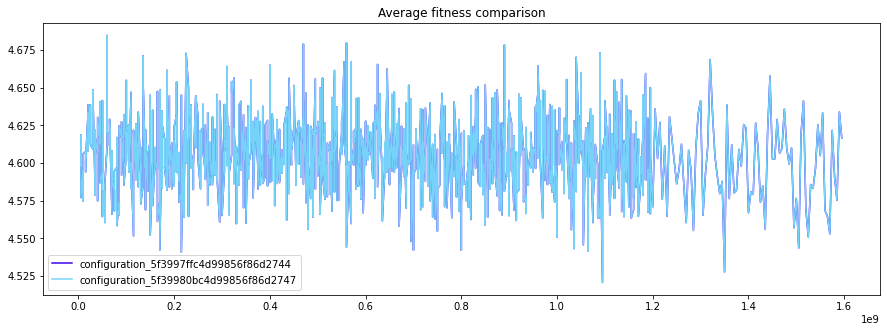

In [17]:
# Use case 4. Compare all configurations for experiment

series = cb_analytics.compare_configurations_for_experiment(
    experiment_name=age_log_experiment_name,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

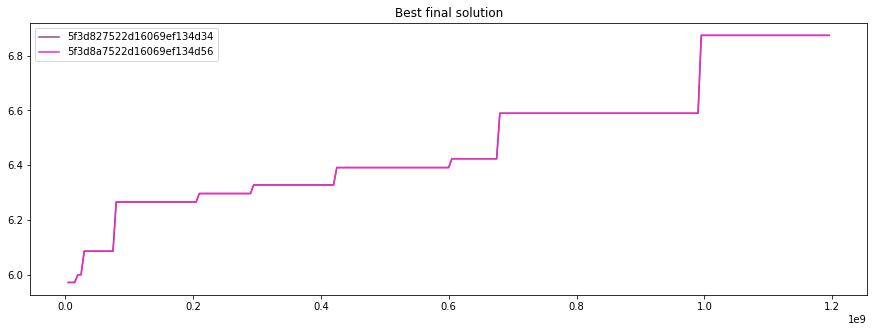

In [18]:
# Use case 5.1 Get best computations (optimization) by their final values

series = cb_analytics.best_n_computations(
    n=2,
    field_name='BEST_SOLUTION_SO_FAR',
    goal=cb.OptimizationGoal.MAX,
    kind=cb.OptimizationKind.FINAL_VALUE
)

cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field='BEST_SOLUTION_SO_FAR',
                           title='Best final solution')


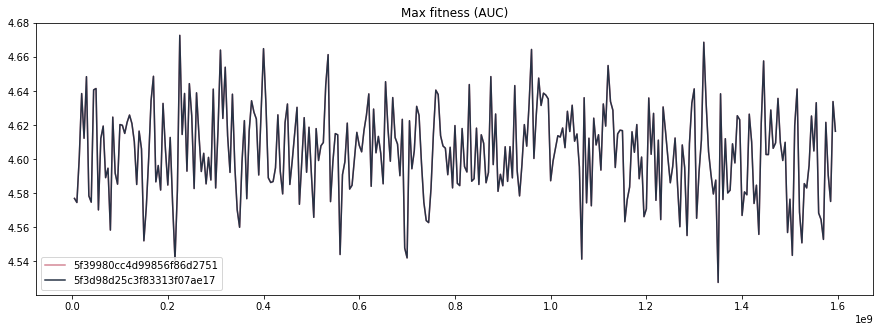

In [19]:
# Use case 5.2 Get best computations (optimization) by convergence (area under curve / integral)

series = cb_analytics.best_n_computations(
    n=2,
    field_name='AVERAGE_FITNESS',
    goal=cb.OptimizationGoal.MAX,
    kind=cb.OptimizationKind.AREA_UNDER_CURVE
)

cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field='AVERAGE_FITNESS',
                           title='Max fitness (AUC)')


In [20]:
# Get mean and stddev for given computations
field_name = 'AVERAGE_FITNESS'


series = cb_analytics.avg_and_stddev_for_computations(
    computation_ids=computation_ids,
    field_name=field_name,
    interval=10,
    time_unit=cb.TimeUnit.DAYS,
)

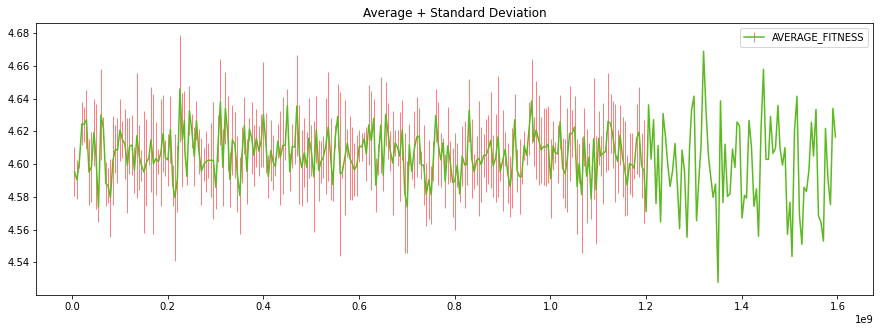

In [21]:
cb.DataSeriesPlots.compare(series=[series],
                           x_field='_time',
                           y_field='AVG',
                           yerr_field='STDDEV',
                           title='Average + Standard Deviation')